In [1]:
#TESTING CHANGES HERE FOR GIT PUSH##

""" This notebook walks you through an example of how to write and run a deterministic age stratified SIR 
    model with the contact matrices we provide in this repository."""
import numpy as np
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt

import copy
import os
import warnings


# set the font family style
mplt.rcParams['font.family'] = 'Roboto Condensed'  # change to a font you have installed on your computer - checkout Google Fonts for free font available for download
mplt.rcParams['font.size'] = 22  # increase default font size

# set the random seed
seed = 0
np.random.seed(0)

In [2]:
# set some initial paths to the data folder and some other useful folders
# thisdir = os.path.abspath('')

# datadir = os.path.join(os.path.split(thisdir)[0], 'data')
# figdir = os.path.join(os.path.split(thisdir)[0], 'figures')

# # read in dataframes with location and associated country names
# location_file = os.path.join(datadir, 'location_country_names.csv')
# locations_df = pd.read_csv(location_file, delimiter = ',')


# # set the font family style
# mplt.rcParams['font.family'] = 'Myriad Pro'  # change to a font you have installed on your computer - checkout Google Fonts for free fonts available for download

# set some initial paths

# path to the directory where this script lives
thisdir = os.path.abspath('/Users/audreyweaver/Desktop/CSCI3352/Project/Project_ref_files/mixing-patterns')

# path to the main directory of the repository
maindir = os.path.split(os.path.split(thisdir)[0])[0]

# path to the analysis_results subdirectory
analysisdir = os.path.join(thisdir, 'analysis_results')
# analysis_path = os.path.dirname(os.path.abspath('location_country_names.csv'))
# print(analysis_path)

# path to the data subdirectory
datadir = os.path.join(thisdir, 'data')

# path to the figures subdirectory within analysis_results
figdir = os.path.join(analysisdir, 'figures')

location_file = os.path.join(analysisdir, 'location_country_names.csv')
locations_df = pd.read_csv(location_file, delimiter = ',')

In [3]:
def get_country_name(df,location):
    """
    Return country name of the location

    Args:
        df (pandas Dataframe) : dataframe containing locations and corresponding countries
        location (str)        : name of the location

    Returns:
        str: Name of the country the location is in.
    """
    d = df[df.location == location]
    return d.country.values[0]

In [4]:
def get_locations_by_country(df,country):
    """
    Return locations in the country

    Args:
        df (pandas Dataframe) : dataframe containing locations and corresponding countries
        country (str)         : name of the country

    Returns:
        str: Name of the country the location is in.
    """
    locations = list(df[df.country == country].location.values)
    return locations

In [5]:
def read_contact_matrix(location, country, level, setting, num_agebrackets=85):
    """
    Read in the contact for each setting.

    Args:
        location (str)        : name of the location
        country (str)         : name of the country
        level (str)           : name of level (country or subnational)
        setting (str)         : name of the contact setting
        num_agebrackets (int) : the number of age brackets for the matrix

    Returns:
        A numpy matrix of contact.
    """
    setting_type, setting_suffix = 'F', 'setting'
    if setting == 'overall':
        setting_type, setting_suffix = 'M', 'contact_matrix'

    if country == 'Europe':
        country = location
        level = 'country'
    if level == 'country':
        file_name = country + '_' + level + '_level_' + setting_type + '_' + setting + '_' + setting_suffix + '_' + '%i' % num_agebrackets + '.csv'
    else:
        file_name = country + '_' + level + '_' + location + '_' + setting_type + '_' + setting + '_' + setting_suffix + '_' + '%i' % num_agebrackets + '.csv'
    file_path = os.path.join(datadir, 'contact_matrices', file_name)
    return np.loadtxt(file_path, delimiter=',')

In [6]:
def get_contact_matrix_dic(location, country, level, num_agebrackets=85):
    """
    Get a dictionary of the setting contact matrices for a location.
    
    Args:
        location (str)        : name of the location
        country (str)         : name of the country
        level (str)           : name of level (country or subnational)
        num_agebrackets (int) : the number of age brackets for the matrix
    
    Returns:
        dict: A dictionary of the setting contact matrices for the location.
    """
    settings = ['household', 'school', 'work', 'community']
    matrix_dic = {}
    for setting in settings:
        matrix_dic[setting] = read_contact_matrix(location, country, level, setting, num_agebrackets)
    return matrix_dic

In [7]:
def get_ages(location, country, level, num_agebrackets=85):
    """
    Get the age count for the synthetic population of the location.

    Args:
        location (str)        : name of the location
        country (str)         : name of the country
        level (str)           : name of level (country or subnational)
        num_agebrackets (int) : the number of age brackets

    Returns:
        dict: A dictionary of the age count.
    """

    if country == 'Europe':
        country = location
        level = 'country'
    if level == 'country':
        file_name = country + '_' + level + '_level_age_distribution_' + '%i' % num_agebrackets + '.csv'
    else:
        file_name = country + '_' + level + '_' + location + '_age_distribution_' + '%i' % num_agebrackets + '.csv'
    file_path = os.path.join(datadir, 'age_distributions', file_name)
    df = pd.read_csv(file_path, delimiter=',', header=None)
    df.columns = ['age', 'age_count']
    return dict(zip(df.age.values.astype(int), df.age_count.values))

In [8]:
def get_eigenvalue(matrix):
    """
    Get the real component of the leading eigenvalue of a square matrix.

    Args:
        matrix (np.ndarray): square matrix

    Returns:
        float: Real component of the leading eigenvalue of the matrix.
    """
    eigenvalue = max(np.linalg.eigvals(matrix)).real
    return eigenvalue

In [9]:
def get_age_effective_contact_matrix_with_factor_vector(contact_matrix, susceptibility_factor_vector):
    """
    Get an effective age specific contact matrix with an age dependent susceptibility drop factor.

    Args:
        contact_matrix (np.ndarray)        : the contact matrix
        susceptibility_factor_vector (int): vector of age specific susceptibility, where the value 1 means fully susceptibility and 0 means unsusceptible.


    Returns:
        np.ndarray: A numpy square matrix that gives the effective contact matrix given an age dependent susceptibility drop factor.
    """
    effective_matrix = contact_matrix * susceptibility_factor_vector
    return effective_matrix

In [10]:
def get_R0_with_factor_vector(beta, susceptibility_factor_vector, num_agebrackets, gamma_inverse, contact_matrix):
    """
    Get the basic reproduction number R0 for a SIR compartmental model with an age dependent susceptibility drop factor and the age specific contact matrix.

    Args:
        beta (float)                              : the transmissibility
        susceptibility_factor_vector (np.ndarray) : vector of age specific susceptibility, where the value 1 means fully susceptibility and 0 means unsusceptible.
        num_agebrackets (int)                     : the number of age brackets of the contact matrix
        gamma_inverse (float)                     : the mean recovery period
        contact_matrix (np.ndarray)               : the contact matrix

    Returns:
        float: The basic reproduction number for a SIR compartmental model with an age dependent susceptibility drop factor and age specific contact patterns.
    """
    gamma = 1./gamma_inverse
    effective_matrix = get_age_effective_contact_matrix_with_factor_vector(contact_matrix.T, susceptibility_factor_vector)
    eigenvalue = get_eigenvalue( effective_matrix )
    R0 = beta * eigenvalue / gamma
    return R0

In [11]:
def get_beta_with_factor_vector(R0, susceptibility_factor_vector, num_agebrackets, gamma_inverse, contact_matrix):
    """
    Get the transmissibility beta for an SIR model with an age dependent susceptibility drop factor and the age specific contact matrix.

    Args:
        R0 (basic reproduction number)            : the basic reproduction number
        susceptibility_factor_vector (np.ndarray) : vector of age specific susceptibility, where the value 1 means fully susceptibility and 0 means unsusceptible.
        num_agebrackets (int)                     : the number of age brackets of the contact matrix
        gamma_inverse (float)                     : the mean recovery period
        contact_matrix (np.ndarray)               : the contact matrix

    Returns:
        float: The transmissibility beta for an SIR compartmental model with an age dependent susceptibility drop factor and age specific contact patterns.
    """
    gamma = 1./gamma_inverse
    effective_matrix = get_age_effective_contact_matrix_with_factor_vector(contact_matrix.T, susceptibility_factor_vector)
    eigenvalue = get_eigenvalue( effective_matrix )
    beta = R0 * gamma / eigenvalue
    return beta

In [12]:
def combine_synthetic_matrices(contact_matrix_dic, weights, num_agebrackets=85):
    """
    A linear combination of contact matrices for different settings to create an overall contact matrix given the weights for each setting.

    Args:
        contact_matrix_dic (dict) : a dictionary of contact matrices for different settings of contact. All setting contact matrices must be square and have the dimensions (num_agebrackets, num_agebrackets).
        weights (dict)            : a dictionary of weights for each setting of contact
        num_agebrackets (int)     : the number of age brackets of the contact matrix

    Returns:
        np.ndarray: A linearly combined overall contact matrix.
    """
    contact_matrix = np.zeros((num_agebrackets,num_agebrackets))
    for setting in weights:
        contact_matrix += contact_matrix_dic[setting] * weights[setting]
    return contact_matrix

In [13]:
def sir_with_age_specific_contact_matrix(contact_matrix_dic, weights, ages, beta, susceptibility_factor_vector, gamma_inverse, initial_infected_age, percent_of_initial_infected_seeds, num_agebrackets, timesteps):
    """
    Deterministic, compartmental, age stratified Susceptible-Infected-Recovered (SIR) model of infectious disease transmission in a population with age specific contact matrices and age specific susceptibility.

    Args:
        contact_matrix_dic (dict)                 : a dictionary of contact matrices for different settings of contact. All setting contact matrices must be square and have the dimensions (num_agebrackets, num_agebrackets).
        weights (dict)                            : a dictionary of weights for each setting of contact
        ages (dict)                               : a dictionary of the age count of people in the population
        beta (float)                              : the transmissibility
        susceptibility_factor_vector (np.ndarray) : vector of age specific susceptibility, where the value 1 means fully susceptibility and 0 means unsusceptible.
        # susceptibility_drop_factor (float)      : susceptibility drop factor
        # susceptibility_drop_age (int)           : age at which susceptibility drops
        gamma_inverse (float)                     : the mean recovery period 
        initial_infected_age (int)                : the initial age seeded with infections
        percent_of_initial_infected_seeds (float) : percent of the population initially seeded with infections.
        num_agebrackets (int)                     : the number of age brackets of the contact matrix
        timesteps (int)                           : the number of timesteps
    
    Returns:
        A numpy array with the number of people in each disease state (S-I-R) by age for each timestep, a numpy array with the incidence by setting and age for each timestep, the disease state indices, and the setting indices.
    """

    gamma = 1./gamma_inverse
    total_population = sum(ages.values())
    initial_infected_number = min(total_population * percent_of_initial_infected_seeds, ages[initial_infected_age])
    num_agebrackets = len(ages)

    # simulation output
    states = np.zeros((3, num_agebrackets, timesteps + 1))
    incidence_by_setting = np.zeros((4, num_agebrackets, timesteps))

    # indices
    susceptible = 0
    infected = 1
    recovered = 2
    indices = {'susceptible': 0, 'infected': 1, 'recovered': 2}

    # setting indices
    household = 0
    school = 1
    work = 2
    community = 3
    setting_indices = {'household': 0, 'school': 1, 'work': 2, 'community': 3}

    settings = ['household', 'school', 'work', 'community']

    # initial conditions
    states[infected][initial_infected_age][0] = initial_infected_number
    for a in range(num_agebrackets):
        states[susceptible][a][0] = copy.deepcopy(ages[a]) - states[infected][a][0]

    age_effective_contact_matrix_dic = {}
    for setting in contact_matrix_dic:
        age_effective_contact_matrix_dic[setting] = get_age_effective_contact_matrix_with_factor_vector(contact_matrix_dic[setting], susceptibility_factor_vector)

    for t in range(timesteps):
        for i in range(num_agebrackets):
            for j in range(num_agebrackets):
                for k, setting in enumerate(settings):
                    incidence_by_setting[k][i][t] += beta * weights[setting] * age_effective_contact_matrix_dic[setting][i][j] * states[susceptible][i][t] * states[infected][j][t] / ages[j]

            states[susceptible][i][t+1] = states[susceptible][i][t] - incidence_by_setting[:, i, t].sum()
            states[infected][i][t+1] = states[infected][i][t] + incidence_by_setting[:, i, t].sum() - gamma * states[infected][i][t]
            states[recovered][i][t+1] = states[recovered][i][t] + gamma * states[infected][i][t]

    return states, incidence_by_setting, indices, setting_indices

In [16]:
#IMPLIMENT SIR
# all countries available
countries = ['Australia', 'Canada', 'China', 'Europe', 'India', 'Israel', 'Japan', 'Russia', 'South_Africa', 'United_States']

# all subnational locations available, plus Israel
locations = []
for country in countries:
    locations += get_locations_by_country(locations_df, country)
    if country in locations and country != 'Israel':
        locations.remove(country)

    if country == 'India':
        locations.remove('Dadra_and_Nagar_Haveli')
        locations.remove('Chandigarh')
        locations.remove('Lakshadweep')

# or... instead choose just a handful of locations
#locations = locations[::10]  # every 10th location

# SIR model parameters
num_agebrackets = 85  # number of age brackets for the contact matrices
R0_star = 1.6  # basic reproduction number
gamma_inverse = 2.6  # mean recovery period
initial_infected_age = 20  # some initial age to seed infections within the population
percent_of_initial_infected_seeds = 1e-5
timesteps = 350  # how long to run the SIR model

weights = {'household': 4.11, 'school': 11.41, 'work': 8.07, 'community': 2.79}  # effective setting weights as found in our study

# define the vector of susceptibility by age

# Example 1: past 18 the suseptibility of individuals drops to a relative factor of 0.6 of those under 18
susceptibility_factor_vector = np.ones((num_agebrackets, 1))
for a in range(18, num_agebrackets):
    susceptibility_factor_vector[a, :] *= 0.6
    
# # Example 2: under 18 the susceptibility of individuals drops to 0.2, from 18 to 65 the susceptibility is 0.8, and those 65 and over are fully susceptible to the disease.
# susceptibility_factor_vector = np.ones((num_agebrackets, 1))
# for a in range(0, 18):
#     susceptibility_factor_vector[a, :] *= 0.2
# for a in range(18, 65):
#     susceptibility_factor_vector[a, :] *= 0.8
    

# define a reference location - use the location you want to fix the basic reproduction number, and thus the reference beta for
reference_location = 'New_York'
reference_country = get_country_name(locations_df, reference_location)

if reference_location == 'Israel':
    reference_level = 'country'
else:
    reference_level = 'subnational'

# get the contact matrices for the reference location to calculate the reference beta
reference_contact_matrix_dic = get_contact_matrix_dic(reference_location, reference_country, reference_level, num_agebrackets)
reference_contact_matrix = combine_synthetic_matrices(reference_contact_matrix_dic, weights, num_agebrackets)
reference_beta = get_beta_with_factor_vector(R0_star, susceptibility_factor_vector, num_agebrackets, gamma_inverse, reference_contact_matrix)


# run the SIR model for a few locations 
R0_list = []
attack_rate_list = []
results_by_location = {}

for n, location in enumerate(locations):

    country = get_country_name(locations_df, location)
    if location == 'Israel':
        level = 'country'
    else:
        level = 'subnational'
    print(location)
    contact_matrix = read_contact_matrix(location, country, level, 'overall', num_agebrackets)
    contact_matrix_dic = get_contact_matrix_dic(location, country, level, num_agebrackets)
    ages = get_ages(location, country, level, num_agebrackets)
    

    R0 = get_R0_with_factor_vector(reference_beta, susceptibility_factor_vector, num_agebrackets, gamma_inverse, contact_matrix)
    states, incidence_by_setting, indices, setting_indices = sir_with_age_specific_contact_matrix(contact_matrix_dic, weights, ages, reference_beta,
                                         susceptibility_factor_vector,
                                         gamma_inverse, initial_infected_age, percent_of_initial_infected_seeds, num_agebrackets, timesteps)

    R0_list.append(R0)
    attack_rate_list.append(states[indices['recovered'], :, -1].sum() / sum(ages.values()) * 100)
    
    results_by_location[location] = {'states': states.copy(), 'incidence_by_setting': incidence_by_setting.copy()}

    

NameError: name 'countries' is not defined

In [87]:
def seir_with_age_specific_contact_matrix(contact_matrix_dic, weights, ages, beta, susceptibility_factor_vector, sigma_inverse, gamma_inverse, initial_infected_age, percent_of_initial_infected_seeds, num_agebrackets, timesteps):
    """
    Deterministic, compartmental, age-stratified Susceptible-Exposed-Infected-Recovered (SEIR) model of infectious disease transmission 
    in a population with age-specific contact matrices and age-specific susceptibility.

    Args:
        contact_matrix_dic (dict): A dictionary of contact matrices for different settings of contact. All setting contact matrices must be square and have the dimensions (num_agebrackets, num_agebrackets).
        weights (dict): A dictionary of weights for each setting of contact.
        ages (dict): A dictionary of the age count of people in the population.
        beta (float): The transmissibility.
        susceptibility_factor_vector (np.ndarray): Vector of age-specific susceptibility, where the value 1 means fully susceptible and 0 means not susceptible.
        sigma_inverse (float): The mean incubation period (1/sigma is the rate of leaving Exposed).
        gamma_inverse (float): The mean recovery period (1/gamma is the rate of leaving Infected).
        initial_infected_age (int): The initial age seeded with infections.
        percent_of_initial_infected_seeds (float): Percent of the population initially seeded with infections.
        num_agebrackets (int): The number of age brackets of the contact matrix.
        timesteps (int): The number of timesteps.

    Returns:
        A numpy array with the number of people in each disease state (S-E-I-R) by age for each timestep, 
        a numpy array with the incidence by setting and age for each timestep, the disease state indices, and the setting indices.
    """

    # Parameters for transitions
    gamma = 1.0 / gamma_inverse  # Recovery rate
    sigma = 1.0 / sigma_inverse  # Incubation rate
    total_population = sum(ages.values())
    initial_infected_number = min(total_population * percent_of_initial_infected_seeds, ages[initial_infected_age])
    num_agebrackets = len(ages)

    # Simulation output
    states = np.zeros((4, num_agebrackets, timesteps + 1))  # 4 compartments: S, E, I, R
    incidence_by_setting = np.zeros((4, num_agebrackets, timesteps))

    # Indices
    susceptible = 0
    exposed = 1
    infected = 2
    recovered = 3
    indices = {'susceptible': 0, 'exposed': 1, 'infected': 2, 'recovered': 3}

    # Setting indices
    household = 0
    school = 1
    work = 2
    community = 3
    setting_indices = {'household': 0, 'school': 1, 'work': 2, 'community': 3}

    settings = ['household', 'school', 'work', 'community']

    # Initial conditions
    states[infected][initial_infected_age][0] = initial_infected_number
    for a in range(num_agebrackets):
        states[susceptible][a][0] = copy.deepcopy(ages[a]) - states[infected][a][0]

    age_effective_contact_matrix_dic = {}
    for setting in contact_matrix_dic:
        age_effective_contact_matrix_dic[setting] = get_age_effective_contact_matrix_with_factor_vector(contact_matrix_dic[setting], susceptibility_factor_vector)

    for t in range(timesteps):
        for i in range(num_agebrackets):
            for j in range(num_agebrackets):
                for k, setting in enumerate(settings):
                    # Incidence from susceptible to exposed
                    incidence_by_setting[k][i][t] += beta * weights[setting] * age_effective_contact_matrix_dic[setting][i][j] * states[susceptible][i][t] * states[infected][j][t] / ages[j]

            # Update compartments
            states[susceptible][i][t+1] = states[susceptible][i][t] - incidence_by_setting[:, i, t].sum()
            states[exposed][i][t+1] = states[exposed][i][t] + incidence_by_setting[:, i, t].sum() - sigma * states[exposed][i][t]
            states[infected][i][t+1] = states[infected][i][t] + sigma * states[exposed][i][t] - gamma * states[infected][i][t]
            states[recovered][i][t+1] = states[recovered][i][t] + gamma * states[infected][i][t]

    return states, incidence_by_setting, indices, setting_indices


In [40]:
#TEST NEW SEIRDQ

def seirdq_with_age_specific_contact_matrix(contact_matrix_dic, weights, ages, beta, susceptibility_factor_vector, sigma_inverse, gamma_inverse, initial_infected_age, percent_of_initial_infected_seeds, num_agebrackets, timesteps):
    """
    SEIRDQ model with mortality rate for individuals above 65 years of age and quarantine step for exposed individuals after a one-time step buffer.

    Args:
        contact_matrix_dic (dict): Contact matrices for different settings.
        weights (dict): Weights for each contact setting.
        ages (dict): Age distribution of the population.
        beta (float): Transmissibility.
        susceptibility_factor_vector (np.ndarray): Age-specific susceptibility.
        sigma_inverse (float): Mean incubation period.
        gamma_inverse (float): Mean recovery period.
        initial_infected_age (int): Initial infected age group.
        percent_of_initial_infected_seeds (float): Percent of infected seeds.
        num_agebrackets (int): Number of age brackets.
        timesteps (int): Number of timesteps.

    Returns:
        numpy array with S-E-I-R-D-Q compartments over time, incidence data, disease state indices, and setting indices.
    """
    # Parameters for transitions
    gamma = 1.0 / gamma_inverse  # Recovery rate
    sigma = 1.0 / sigma_inverse  # Incubation rate
    age_threshold = 65
    mortality_rate_old = 0.2
    mortality_rate_young = 0.05
    mortality_rates = [mortality_rate_old if age > age_threshold else mortality_rate_young for age in range(num_agebrackets)]

    total_population = sum(ages.values())
    initial_infected_number = min(total_population * percent_of_initial_infected_seeds, ages[initial_infected_age])

    # Simulation output
    states = np.zeros((6, num_agebrackets, timesteps + 1))  # 6 compartments: S, E, I, R, D, Q
    incidence_by_setting = np.zeros((4, num_agebrackets, timesteps))

    # Indices
    susceptible =0
    exposed =1
    infected =2
    recovered =3
    death =4
    quarantined =5
    indices = {'susceptible': 0, 'exposed': 1, 'infected': 2, 'recovered': 3, 'death': 4, 'quarantined': 5}

    #settig indices
    household = 0
    school = 1
    work = 2
    community = 3
    setting_indices = {'household': 0, 'school': 1, 'work': 2, 'community': 3}

    settings = ['household', 'school', 'work', 'community']

    quarantine_probabilities = {
        'household': 0.05,  # 5% chance of quarantine if exposed at household
        'school': 0.2,     # 20% chance of quarantine if exposed at school
        'work': 0.1        # 10% chance of quarantine if exposed at work
    }

    # Initial conditions
    states[infected][initial_infected_age][0] = initial_infected_number
    for a in range(num_agebrackets):
        states[susceptible][a][0] = copy.deepcopy(ages[a]) - states[infected][a][0]

    # Contact matrix adjustments
    age_effective_contact_matrix_dic = {}
    for setting in contact_matrix_dic:
        age_effective_contact_matrix_dic[setting] = get_age_effective_contact_matrix_with_factor_vector(contact_matrix_dic[setting], susceptibility_factor_vector)

    
    # store exposed nodes for one timestep before assessing quarantine probability
    # Buffer to track exposed individuals for one timestep
    exposed_buffer = np.zeros((num_agebrackets, timesteps + 1))
    new_exposed_array = np.zeros((num_agebrackets, timesteps + 1))  # Store new_exposed as an array

    # SEIR Model with Mortality and Delayed Quarantine
    for t in range(timesteps):
        for i in range(num_agebrackets):
            new_exposed_by_setting = np.zeros(4)  # Ensure this is a numeric array
            for j in range(num_agebrackets):
                for k, setting in enumerate(['household', 'school', 'work', 'community']):
                    # Transmission to Exposed
                    new_exposed_by_setting[k] += (
                        beta * weights[setting] * age_effective_contact_matrix_dic[setting][i][j]
                        * states[susceptible][i][t] * states[infected][j][t] / max(ages[j], 1e-6)
                    )

            # Sum new exposed
            total_new_exposed = np.sum(new_exposed_by_setting)  # Ensure total_new_exposed is scalar
            total_new_exposed = min(total_new_exposed, states[susceptible][i][t])  # Prevent over-exposure
            states[susceptible][i][t+1] = states[susceptible][i][t] - total_new_exposed
            
            # Store new exposed in buffer and array
            exposed_buffer[i][t+1] = total_new_exposed
            new_exposed_array[i][t+1] = total_new_exposed

            # Decide quarantine for individuals exposed one timestep ago
            if t > 0:
                delayed_exposed = exposed_buffer[i][t]
                new_quarantined = 0.0
                for k, setting in enumerate(['household', 'school', 'work', 'community']):
                    quarantine_prob = quarantine_probabilities.get(setting, 0)
                    quarantined_from_setting = (new_exposed_by_setting[k] / total_new_exposed) * delayed_exposed * quarantine_prob if total_new_exposed > 0 else 0
                    new_quarantined += quarantined_from_setting

                new_exposed = delayed_exposed - new_quarantined
                states[quarantined][i][t+1] = states[quarantined][i][t] + new_quarantined
                states[exposed][i][t+1] = states[exposed][i][t] + new_exposed - sigma * states[exposed][i][t]
            else:
                # No quarantine decision at t=0, all new exposed remain exposed
                states[exposed][i][t+1] = states[exposed][i][t] + total_new_exposed - sigma * states[exposed][i][t]
            
            # Transitions
            new_infected = sigma * states[exposed][i][t]
            new_recovered = gamma * (1 - mortality_rates[i]) * states[infected][i][t]
            new_deaths = gamma * mortality_rates[i] * states[infected][i][t]

            states[infected][i][t+1] = states[infected][i][t] + new_infected - new_recovered - new_deaths
            states[recovered][i][t+1] = states[recovered][i][t] + new_recovered
            states[death][i][t+1] = states[death][i][t] + new_deaths

    return states, incidence_by_setting, indices, {'household': 0, 'school': 1, 'work': 2, 'community': 3}


In [ ]:
#IMPLIMENTATION OF SEIRDQ

# All countries available
countries = ['Australia', 'Canada', 'China', 'Europe', 'India', 'Israel', 'Japan', 'Russia', 'South_Africa', 'United_States']

# All subnational locations available, plus Israel
locations = []
for country in countries:
    locations += get_locations_by_country(locations_df, country)
    if country in locations and country != 'Israel':
        locations.remove(country)

    if country == 'India':
        locations.remove('Dadra_and_Nagar_Haveli')
        locations.remove('Chandigarh')
        locations.remove('Lakshadweep')

# Or... instead choose just a handful of locations
#locations = locations[::30]  # Every 10th location

# SEIRDQ model parameters
num_agebrackets = 85  # Number of age brackets for the contact matrices
R0_star = 1.6  # Basic reproduction number
sigma_inverse = 1.4  # Mean incubation period (days)
gamma_inverse = 2.6  # Mean recovery period (days)
initial_infected_age = 20  # Some initial age to seed infections within the population
percent_of_initial_infected_seeds = 1e-5
timesteps = 350  # How long to run the SEIR model

weights = {'household': 4.11, 'school': 11.41, 'work': 8.07, 'community': 2.79}  # Effective setting weights as found in our study

# Define the vector of susceptibility by age
# Example 1: Past 18, the susceptibility of individuals drops to a relative factor of 0.6 of those under 18
susceptibility_factor_vector = np.ones((num_agebrackets, 1))
for a in range(18, num_agebrackets):
    susceptibility_factor_vector[a, :] *= 0.6

# Define a reference location - use the location you want to fix the basic reproduction number, and thus the reference beta for
reference_location = 'New_York'
reference_country = get_country_name(locations_df, reference_location)

if reference_location == 'Israel':
    reference_level = 'country'
else:
    reference_level = 'subnational'

# Get the contact matrices for the reference location to calculate the reference beta
reference_contact_matrix_dic = get_contact_matrix_dic(reference_location, reference_country, reference_level, num_agebrackets)
reference_contact_matrix = combine_synthetic_matrices(reference_contact_matrix_dic, weights, num_agebrackets)
reference_beta = get_beta_with_factor_vector(R0_star, susceptibility_factor_vector, num_agebrackets, gamma_inverse, reference_contact_matrix)

# Run the SEIRDQ model for a few locations
R0_list_SEIRDQ = []
attack_rate_list_SEIRDQ = []
results_by_location_SEIRDQ = {}

for n, location in enumerate(locations):

    country = get_country_name(locations_df, location)
    if location == 'Israel':
        level = 'country'
    else:
        level = 'subnational'
    print(location)

    # Retrieve contact matrices and population data
    contact_matrix = read_contact_matrix(location, country, level, 'overall', num_agebrackets)
    contact_matrix_dic = get_contact_matrix_dic(location, country, level, num_agebrackets)
    ages = get_ages(location, country, level, num_agebrackets)

    # Calculate the location-specific R0
    R0 = get_R0_with_factor_vector(reference_beta, susceptibility_factor_vector, num_agebrackets, gamma_inverse, contact_matrix)

    # Run the SEIRDQ model
    states, incidence_by_setting, indices, setting_indices = seirdq_with_age_specific_contact_matrix(
        contact_matrix_dic, weights, ages, reference_beta,
        susceptibility_factor_vector, sigma_inverse, gamma_inverse,
        initial_infected_age, percent_of_initial_infected_seeds, num_agebrackets, timesteps
    )

    # Calculate the attack rate (percent of the population that recovers)
    attack_rate = states[indices['recovered'], :, -1].sum() / sum(ages.values()) * 100
    attack_rate_list_SEIRDQ.append(attack_rate)

    # Store results
    R0_list_SEIRDQ.append(R0)
    results_by_location_SEIRDQ[location] = {'states': states.copy(), 'incidence_by_setting': incidence_by_setting.copy()}


Australian_Capital_Territory


In [24]:
def plot_time_series_states(results_by_location, timesteps, location):
    """
    Plot time series of S, I, and R states.

    Args:
        results_by_location (dict): Dictionary containing 'states' and 'incidence_by_setting' for each location.
        timesteps (int): Number of timesteps in the simulation.
        location (str): Location name for which data to plot.
    """
    location_data = results_by_location.get(location)
    if location_data is None:
        raise ValueError(f"Location '{location}' not found in results_by_location.")
    
    states = location_data['states']
    indices = {'susceptible': 0, 'infected': 1, 'recovered': 2}  # Assumes these indices are fixed
    

    time = np.arange(timesteps + 1)
    S = states[indices['susceptible']].sum(axis=0)
    I = states[indices['infected']].sum(axis=0)
    R = states[indices['recovered']].sum(axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(time, S, label='Susceptible', linewidth=2)
    plt.plot(time, I, label='Infected', linewidth=2)
    plt.plot(time, R, label='Recovered', linewidth=2)
    plt.xlabel('Time (timesteps)')
    plt.ylabel('Population')
    plt.title(f'Epidemic Progression Over Time in {location}')
    plt.legend()
    plt.grid()
    plt.show()


findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Fo

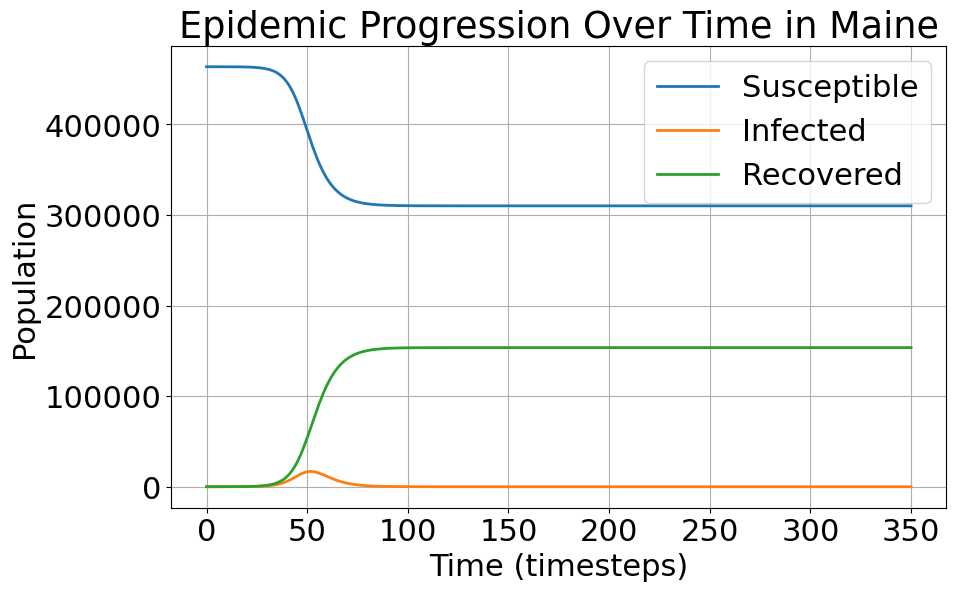

{'states': array([[[4.17900000e+03, 4.17897764e+03, 4.17895485e+03, ...,
         3.12529884e+03, 3.12529884e+03, 3.12529884e+03],
        [5.16900000e+03, 5.16897534e+03, 5.16894928e+03, ...,
         3.85594522e+03, 3.85594522e+03, 3.85594522e+03],
        [6.72300000e+03, 6.72297028e+03, 6.72293821e+03, ...,
         5.00297212e+03, 5.00297212e+03, 5.00297212e+03],
        ...,
        [2.46400000e+03, 2.46399732e+03, 2.46399411e+03, ...,
         2.23210957e+03, 2.23210957e+03, 2.23210957e+03],
        [2.15400000e+03, 2.15399763e+03, 2.15399485e+03, ...,
         1.95621671e+03, 1.95621671e+03, 1.95621671e+03],
        [1.02940000e+04, 1.02939887e+04, 1.02939757e+04, ...,
         9.40307514e+03, 9.40307514e+03, 9.40307514e+03]],

       [[0.00000000e+00, 2.23602073e-02, 3.65527975e-02, ...,
         3.11762406e-15, 2.72795444e-15, 2.38698935e-15],
        [0.00000000e+00, 2.46625100e-02, 4.12319745e-02, ...,
         3.83233467e-15, 3.35333387e-15, 2.93420305e-15],
        [0.000

In [42]:
# Plot SIR Time Series
plot_time_series_states(results_by_location, timesteps, 'Maine')

location_check = results_by_location.get(location)
print(location_check)

findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Fo

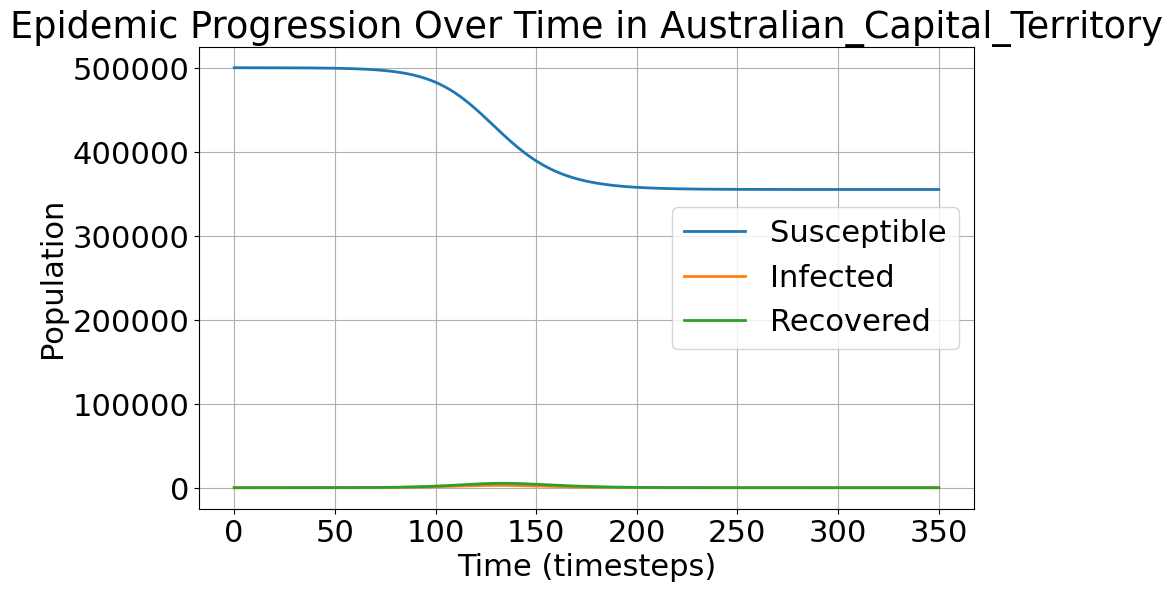

In [39]:
# Plot SEIRDQ Time Series
plot_time_series_states(results_by_location_SEIRDQ, timesteps, 'Australian_Capital_Territory')

In [ ]:
def plot_incidence_by_setting(results_by_location, location, timesteps):
    """
    Plot the incidence of new infections by setting over time for a specific location.

    Args:
        results_by_location (dict): Dictionary containing 'states' and 'incidence_by_setting' for each location.
        location (str): The location for which to plot the incidence.
        timesteps (int): Number of timesteps in the simulation.
    """
    # Retrieve the data for the specified location
    location_data = results_by_location.get(location)
    if location_data is None:
        raise ValueError(f"Location '{location}' not found in results_by_location.")
    
    incidence_by_setting = location_data['incidence_by_setting']
    setting_indices = {'household': 0, 'school': 1, 'work': 2, 'community': 3}  # Assuming these indices are fixed

    # Prepare time and settings
    time = np.arange(timesteps)
    settings = setting_indices.keys()

    # Dynamically determine y-axis range
    ymin = 0
    ymax = incidence_by_setting.sum(axis=1).max() * 1.1  # Add a 10% margin for better visibility

    # Plot
    plt.figure(figsize=(10, 6))
    for setting in settings:
        incidence = incidence_by_setting[setting_indices[setting]].sum(axis=0)  # Sum over age brackets
        plt.plot(time, incidence, label=setting.capitalize(), linewidth=2)

    plt.xlabel('Time (timesteps)')
    plt.ylabel('New Infections')
    plt.title(f'Incidence by Setting Over Time in {location}')
    plt.ylim(ymin, ymax)  # Apply dynamic y-axis limits
    plt.legend()
    plt.grid()
    plt.show()

findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Fo

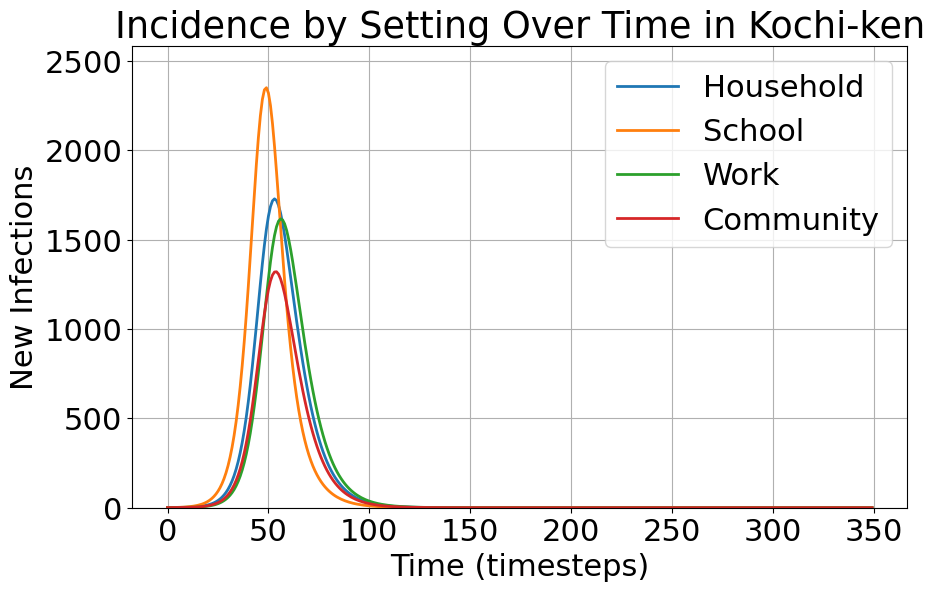

In [104]:
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
plot_incidence_by_setting(results_by_location, 'Kochi-ken', timesteps)

In [76]:
def plot_incidence_by_setting_all_locations(results_by_location, timesteps):
    """
    Plot the incidence of new infections by setting over time for all locations on subplots.

    Args:
        results_by_location (dict): Dictionary containing 'states' and 'incidence_by_setting' for each location.
        timesteps (int): Number of timesteps in the simulation.
    """
    # Prepare time and settings
    time = np.arange(timesteps)
    setting_indices = {'household': 0, 'school': 1, 'work': 2, 'community': 3}
    settings = setting_indices.keys()

    # Define y-axis categories
    ymax_categories = [500, 2500, 3000, 4000, 10000, 25000, 50000]
    grouped_locations = {ymax: [] for ymax in ymax_categories}

    # Group locations by their y-axis max
    for location, data in results_by_location.items():
        incidence_by_setting = data['incidence_by_setting']
        total_incidence = incidence_by_setting.sum(axis=1)  # Total incidence across all settings and age brackets
        ymax_location = total_incidence.max()

        # Find the appropriate ymax category for this location
        for ymax in ymax_categories:
            if ymax_location <= ymax:
                grouped_locations[ymax].append(location)
                break

    # Determine the number of rows and columns
    rows = len([ymax for ymax in ymax_categories if grouped_locations[ymax]])
    cols = max(len(grouped_locations[ymax]) for ymax in ymax_categories)

    # Create figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), constrained_layout=True)

    # Flatten axes for easier indexing, but keep track of row/column structure
    if rows == 1:
        axes = [axes]  # Handle single-row case
    elif cols == 1:
        axes = [[ax] for ax in axes]  # Handle single-column case

    # Plot data for each group
    row_idx = 0
    for ymax in ymax_categories:
        if not grouped_locations[ymax]:
            continue  # Skip empty categories

        col_idx = 0
        for location in grouped_locations[ymax]:
            # Retrieve data for the location
            location_data = results_by_location[location]
            incidence_by_setting = location_data['incidence_by_setting']

            # Plot the data
            ax = axes[row_idx][col_idx]
            for setting in settings:
                incidence = incidence_by_setting[setting_indices[setting]].sum(axis=0)  # Sum over age brackets
                ax.plot(time, incidence, label=setting.capitalize(), linewidth=2)

            ax.set_title(f"{location} (ymax={ymax})", fontsize=14)
            ax.set_xlabel('Time (timesteps)', fontsize=10)
            ax.set_ylabel('New Infections', fontsize=10)
            ax.set_ylim(0, ymax)
            ax.grid()
            ax.legend(fontsize=8)

            col_idx += 1

        # Hide unused subplots in this row
        for col_idx in range(len(grouped_locations[ymax]), cols):
            axes[row_idx][col_idx].axis('off')

        row_idx += 1

    # Add an overall title
    fig.suptitle('Incidence by Setting Over Time Grouped by Y-Axis Categories', fontsize=16)
    plt.show()


findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Fo

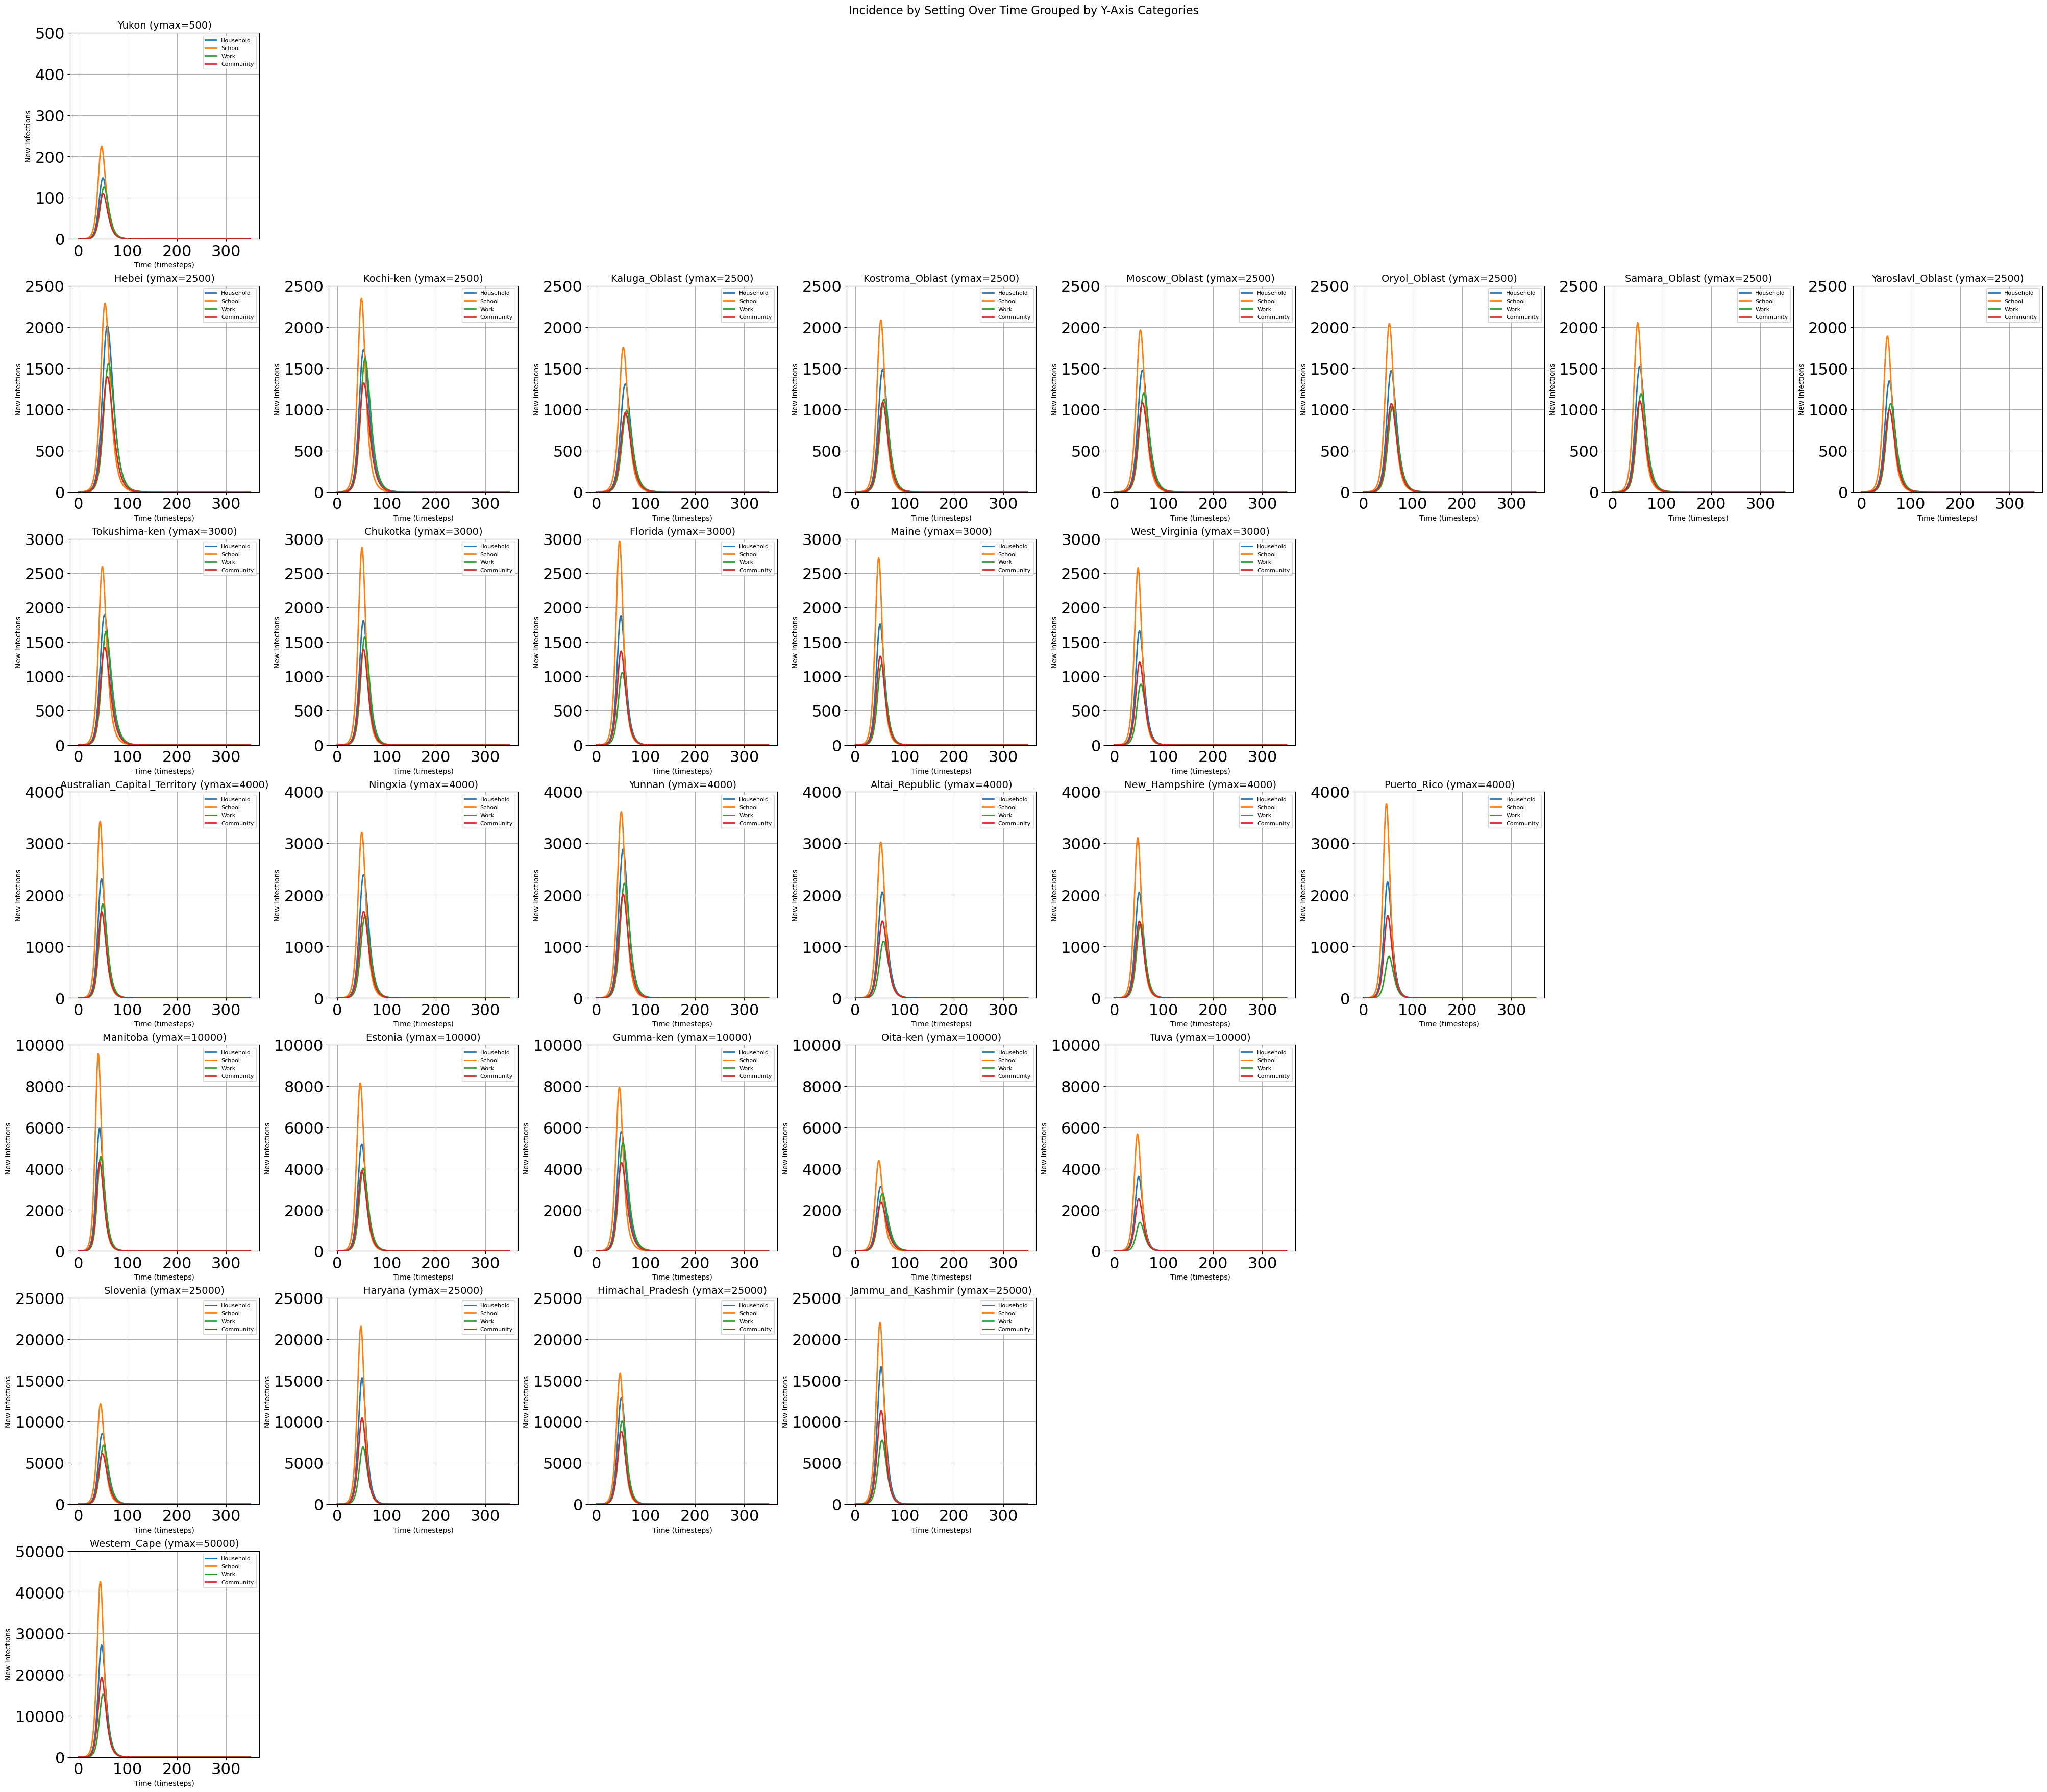

In [77]:
plot_incidence_by_setting_all_locations(results_by_location, timesteps)

In [ ]:
plot_incidence_by_setting_all_locations(results_by_location_SEIRDQ, timesteps)

In [ ]:
def plot_phase_diagram(results_by_location, location, timesteps):
    """
    Plot a phase diagram showing the relationship between I (x-axis) and S (y-axis) over time.

    Args:
        results_by_location (dict): Dictionary containing 'states' and 'incidence_by_setting' for each location.
        location (str): The location for which to plot the phase diagram.
        timesteps (int): Number of timesteps in the simulation.
    """
    # Retrieve the data for the specified location
    location_data = results_by_location.get(location)
    if location_data is None:
        raise ValueError(f"Location '{location}' not found in results_by_location.")
    
    states = location_data['states']
    indices = {'susceptible': 0, 'infected': 1, 'recovered': 2}  # Assuming these indices are fixed

    # Calculate the total S and I populations across all age brackets
    S = states[indices['susceptible']].sum(axis=0)  # Total Susceptible
    I = states[indices['infected']].sum(axis=0)     # Total Infected

    print 
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(I, S, label='Epidemic Trajectory', linewidth=2)

    # Add annotations for start, peak, and end
    plt.scatter(I[0], S[0], color='green', label='Start', zorder=5)  # Start of the epidemic
    plt.scatter(I[-1], S[-1], color='red', label='End', zorder=5)    # End of the epidemic
    peak_idx = I.argmax()
    plt.scatter(I[peak_idx], S[peak_idx], color='orange', label='Peak', zorder=5)  # Peak infection

    # Labels and title
    plt.xlabel('Infected Population (I)', fontsize=12)
    plt.ylabel('Susceptible Population (S)', fontsize=12)
    plt.title(f'Phase Diagram in {location}', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid()

    # Adjust limits for better visualization
    xmin, xmax = I.min() * 0.9, I.max() * 1.1
    ymin, ymax = S.min() * 0.9, S.max() * 1.1
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    plt.show()


findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Fo

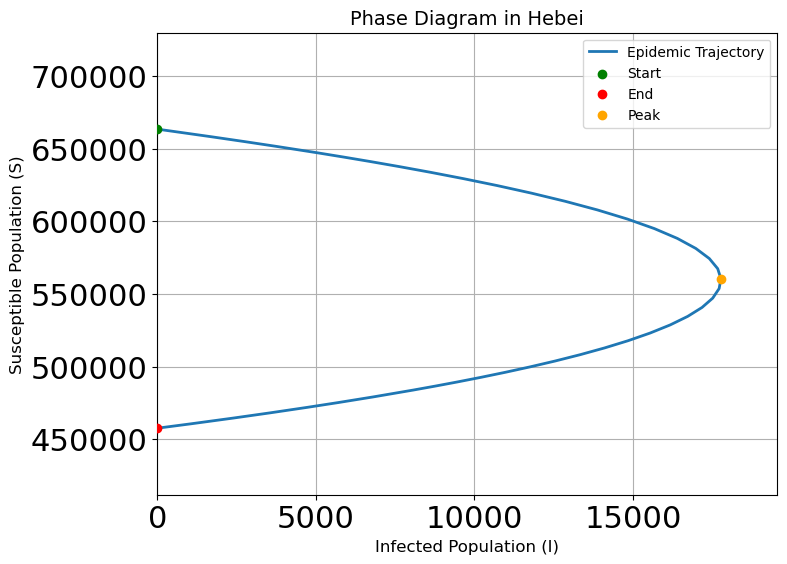

In [84]:
plot_phase_diagram(results_by_location, 'Hebei', timesteps)

In [85]:
def plot_phase_diagram_all_locations(results_by_location, timesteps):
    """
    Plot a phase diagram showing the relationship between I (x-axis) and S (y-axis) over time
    for all locations on the same graph.

    Args:
        results_by_location (dict): Dictionary containing 'states' and 'incidence_by_setting' for each location.
        timesteps (int): Number of timesteps in the simulation.
    """
    # Initialize the plot
    plt.figure(figsize=(10, 8))

    # Loop over all locations
    for location, location_data in results_by_location.items():
        # Retrieve states and indices
        states = location_data['states']
        indices = {'susceptible': 0, 'infected': 1, 'recovered': 2}  # Assuming these indices are fixed

        # Calculate the total S and I populations across all age brackets
        S = states[indices['susceptible']].sum(axis=0)  # Total Susceptible
        I = states[indices['infected']].sum(axis=0)     # Total Infected

        # Plot the trajectory for this location
        plt.plot(I, S, label=f"{location}", linewidth=2)

    # Labels and title
    plt.xlabel('Infected Population (I)', fontsize=12)
    plt.ylabel('Susceptible Population (S)', fontsize=12)
    plt.title('Phase Diagram: S vs. I for All Locations', fontsize=14)

    # Add legend and grid
    plt.legend(fontsize=10, loc='upper right')
    plt.grid()

    # Show the plot
    plt.show()


findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Fo

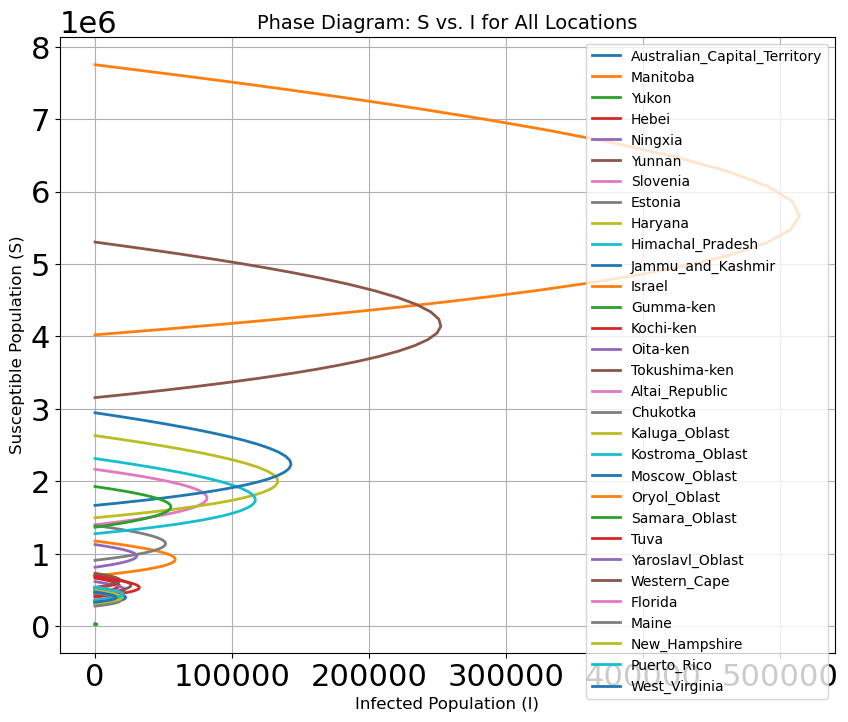

In [86]:
plot_phase_diagram_all_locations(results_by_location, timesteps)

In [ ]:
plot_phase_diagram_all_locations(results_by_location_SEIRDQ, timesteps)

Text(0, 0.5, 'Attack Rate (%)')

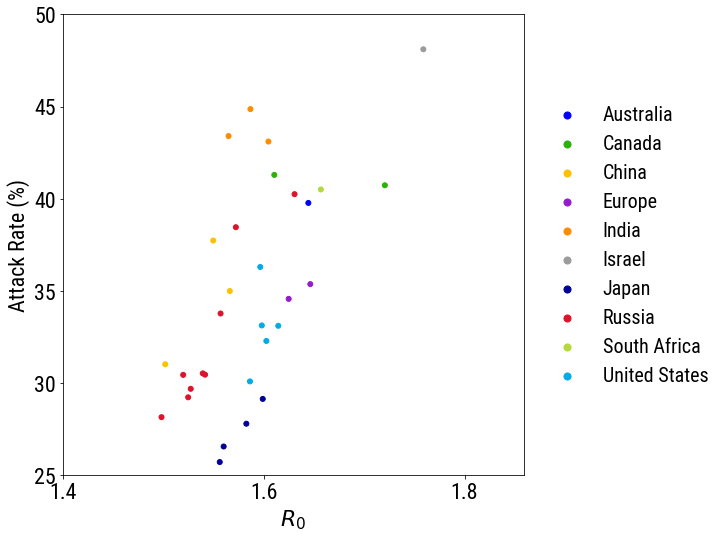

In [ ]:
# Plot the attack rate vs R0 for SIR
country_colour_dic = {}
country_colour_dic['Australia'] = '#0000ff'
country_colour_dic['Canada'] = '#2ab207'
country_colour_dic['China'] = '#fcc200'
country_colour_dic['Europe'] = '#941cca'
country_colour_dic['India'] = 'darkorange'
country_colour_dic['Israel'] = '#9b9b9b'
country_colour_dic['Japan'] = '#000098'
country_colour_dic['Russia'] = '#dc142b'
country_colour_dic['South_Africa'] = '#b5d93c'
country_colour_dic['United_States'] = '#00ace7'

color_list = [country_colour_dic[get_country_name(locations_df, location)] for n, location in enumerate(locations)]

size = 25

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
ax.scatter(R0_list, attack_rate_list, color=color_list, marker='o', s=size)

for country in ['Australia','Canada','China','Europe','India','Israel','Japan','Russia','South_Africa','United_States']:
    ax.scatter(np.nan, np.nan, color = country_colour_dic[country], s = size * 2, label = country.replace('-',' ').replace('_',' '))
leg = ax.legend(loc = 7, fontsize = 20, ncol = 1, bbox_to_anchor = (0.44,0.4,1,0.2))
leg.draw_frame(False)

xinterval = 0.2
xmin = 1.4
xmax = max(R0_list) + 0.1
ax.set_xlim(xmin, xmax)
ax.set_xticks(np.arange(xmin, xmax+0.01, 0.2))

yinterval = 5
ymin = int(min(attack_rate_list)/yinterval) * yinterval
ymax = (int(max(attack_rate_list)/yinterval) + 1) * yinterval
ax.set_ylim(ymin, ymax)
ax.set_yticks(np.arange(ymin, ymax+1, yinterval))
ax.tick_params(labelsize=22)

ax.set_xlabel(r'$R_0$', fontsize = 22)
ax.set_ylabel('Attack Rate (%)', fontsize = 22)

Text(0, 0.5, 'Attack Rate (%)')

findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Fo

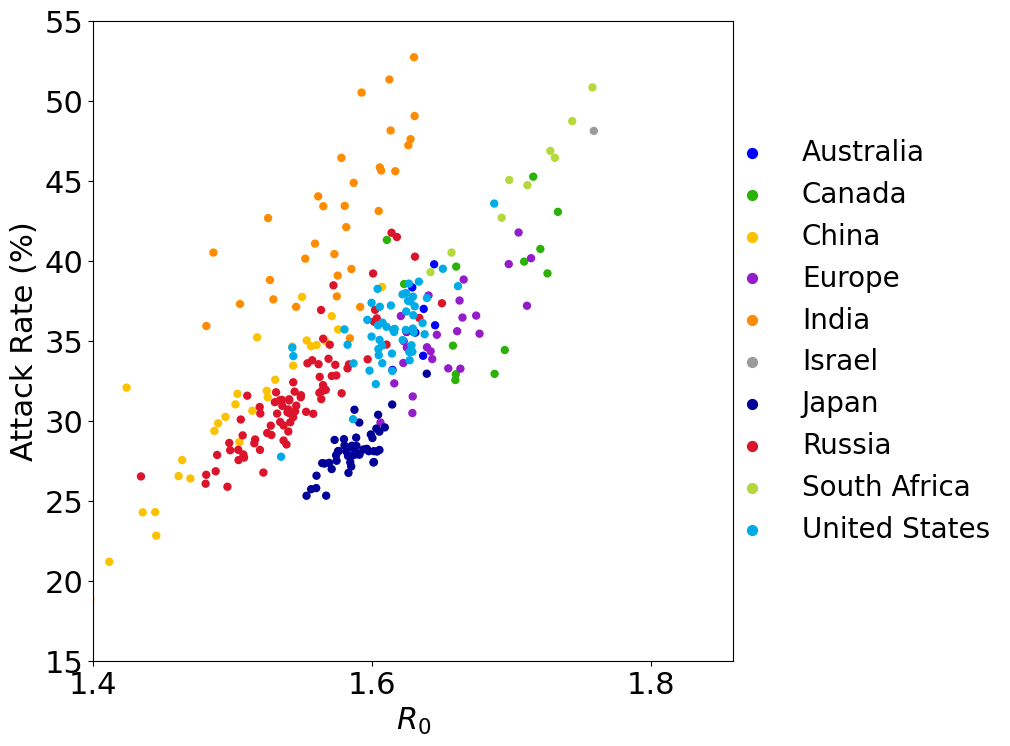

In [100]:
# Plot the attack rate vs R0 for SEIRDQ
country_colour_dic = {}
country_colour_dic['Australia'] = '#0000ff'
country_colour_dic['Canada'] = '#2ab207'
country_colour_dic['China'] = '#fcc200'
country_colour_dic['Europe'] = '#941cca'
country_colour_dic['India'] = 'darkorange'
country_colour_dic['Israel'] = '#9b9b9b'
country_colour_dic['Japan'] = '#000098'
country_colour_dic['Russia'] = '#dc142b'
country_colour_dic['South_Africa'] = '#b5d93c'
country_colour_dic['United_States'] = '#00ace7'

color_list = [country_colour_dic[get_country_name(locations_df, location)] for n, location in enumerate(locations)]

size = 25

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
ax.scatter(R0_list_SEIRDQ, attack_rate_list_SEIRDQ, color=color_list, marker='o', s=size)

for country in ['Australia','Canada','China','Europe','India','Israel','Japan','Russia','South_Africa','United_States']:
    ax.scatter(np.nan, np.nan, color = country_colour_dic[country], s = size * 2, label = country.replace('-',' ').replace('_',' '))
leg = ax.legend(loc = 7, fontsize = 20, ncol = 1, bbox_to_anchor = (0.44,0.4,1,0.2))
leg.draw_frame(False)

xinterval = 0.2
xmin = 1.4
xmax = max(R0_list) + 0.1
ax.set_xlim(xmin, xmax)
ax.set_xticks(np.arange(xmin, xmax+0.01, 0.2))

yinterval = 5
ymin = int(min(attack_rate_list_SEIRDQ)/yinterval) * yinterval
ymax = (int(max(attack_rate_list_SEIRDQ)/yinterval) + 1) * yinterval
ax.set_ylim(ymin, ymax)
ax.set_yticks(np.arange(ymin, ymax+1, yinterval))
ax.tick_params(labelsize=22)

ax.set_xlabel(r'$R_0$', fontsize = 22)
ax.set_ylabel('Attack Rate (%)', fontsize = 22)

In [95]:
# Gut check for Matrix size
print(R0_list_SEIRDQ)
print(f"Length of SIR R0 list: {len(R0_list)}")
print(f"Length of SIR R0 list: {len(attack_rate_list)}")

[]
Length of SIR R0 list: 303
Length of SIR R0 list: 303


Text(0, 0.5, 'Attack Rate (%)')

findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family ['Roboto Condensed'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Condensed' not found.
findfont: Font family 'Roboto Con

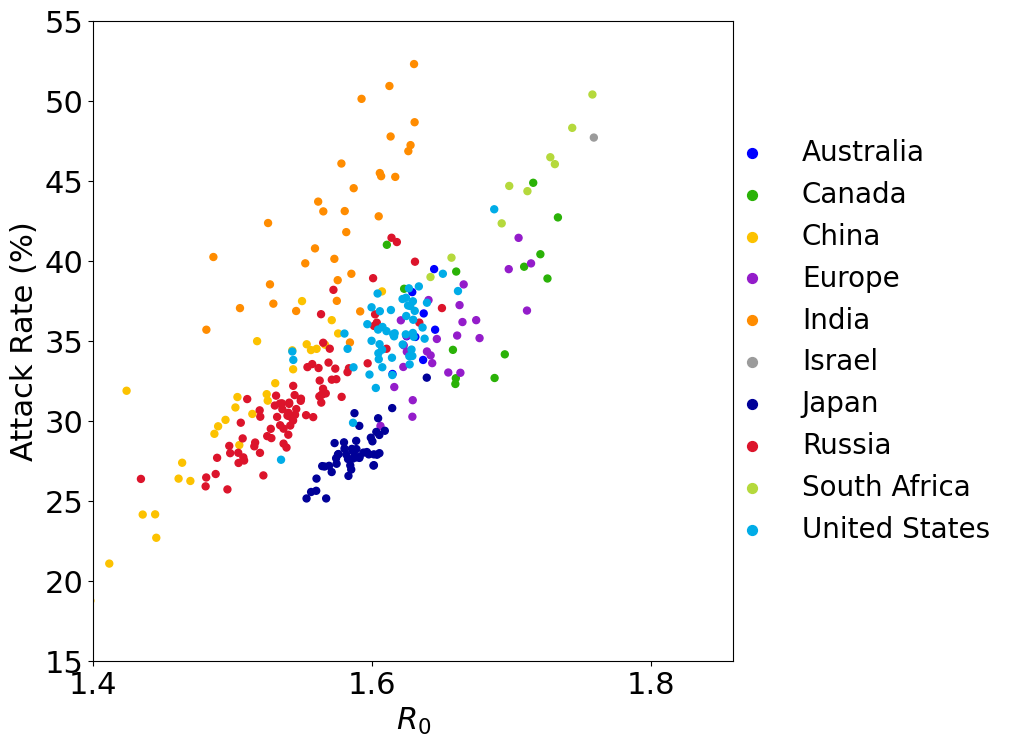

In [96]:
# Plot the attack rate vs R0 for SEIR
#DELETE THIS CELL AS LONG AS THE ONE ABOVE RUNS
country_colour_dic = {}
country_colour_dic['Australia'] = '#0000ff'
country_colour_dic['Canada'] = '#2ab207'
country_colour_dic['China'] = '#fcc200'
country_colour_dic['Europe'] = '#941cca'
country_colour_dic['India'] = 'darkorange'
country_colour_dic['Israel'] = '#9b9b9b'
country_colour_dic['Japan'] = '#000098'
country_colour_dic['Russia'] = '#dc142b'
country_colour_dic['South_Africa'] = '#b5d93c'
country_colour_dic['United_States'] = '#00ace7'

color_list = [country_colour_dic[get_country_name(locations_df, location)] for n, location in enumerate(locations)]

size = 25

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
ax.scatter(R0_list, attack_rate_list, color=color_list, marker='o', s=size)

for country in ['Australia','Canada','China','Europe','India','Israel','Japan','Russia','South_Africa','United_States']:
    ax.scatter(np.nan, np.nan, color = country_colour_dic[country], s = size * 2, label = country.replace('-',' ').replace('_',' '))
leg = ax.legend(loc = 7, fontsize = 20, ncol = 1, bbox_to_anchor = (0.44,0.4,1,0.2))
leg.draw_frame(False)

xinterval = 0.2
xmin = 1.4
xmax = max(R0_list) + 0.1
ax.set_xlim(xmin, xmax)
ax.set_xticks(np.arange(xmin, xmax+0.01, 0.2))

yinterval = 5
ymin = int(min(attack_rate_list)/yinterval) * yinterval
ymax = (int(max(attack_rate_list)/yinterval) + 1) * yinterval
ax.set_ylim(ymin, ymax)
ax.set_yticks(np.arange(ymin, ymax+1, yinterval))
ax.tick_params(labelsize=22)

ax.set_xlabel(r'$R_0$', fontsize = 22)
ax.set_ylabel('Attack Rate (%)', fontsize = 22)

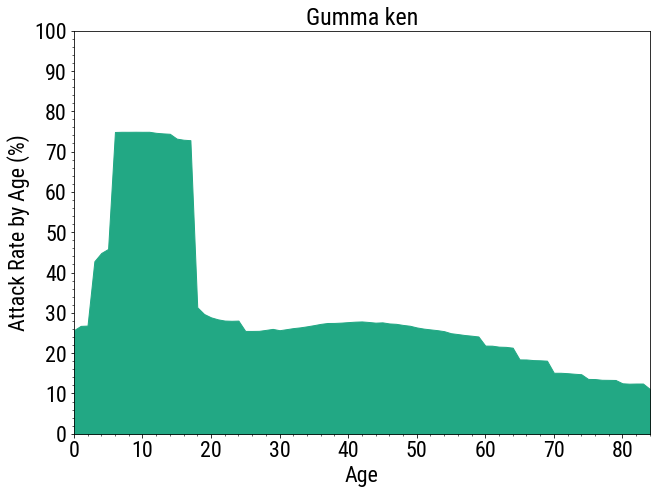

In [16]:
# Plot the attack rate by age for one location
color_list = [country_colour_dic[get_country_name(locations_df, location)] for n, location in enumerate(locations)]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

location = np.random.choice(list(results_by_location.keys()))  # choose one location
country = get_country_name(locations_df, location)

if location == 'Israel':
    level = 'country'
else:
    level = 'subnational'
ages = get_ages(location, country, level, num_agebrackets)

a_range = np.arange(num_agebrackets)
attack_rates_by_age = [results_by_location[location]['states'][indices['recovered'], a, -1] / ages[a] * 100 for a in a_range]

cmap = plt.get_cmap('viridis')
color = cmap(0.6)
ax.fill_between(x=a_range, y1=0, y2=attack_rates_by_age, color=color)

ax.set_xlim(0, num_agebrackets-1)
ax.set_xticks(np.arange(0, num_agebrackets, 10))

yinterval = 10
ax.set_ylim(0, 100)
ax.set_yticks(np.arange(0, 101, yinterval))
ax.set_title(location.replace('_', ' ').replace('-', ' '), fontsize=24)

ax.set_xlabel('Age', fontsize = 22)
ax.set_ylabel('Attack Rate by Age (%)', fontsize = 22)
ax.tick_params(labelsize=22)

plt.minorticks_on()